In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
plt.style.use('default')
pd.set_option('display.max_columns', None)

In [2]:
with open("../Data/simu8_df_46.pkl", 'rb') as inp:
    df_simu_46 = pickle.load(inp)
with open("../Data/simu8_df_64.pkl", 'rb') as inp:
    df_simu_64 = pickle.load(inp)
with open("../Data/simu8_df_44.pkl", 'rb') as inp:
    df_simu_44 = pickle.load(inp)
with open("../Data/simu8_df_66.pkl", 'rb') as inp:
    df_simu_66 = pickle.load(inp)

In [3]:
df_simu_64

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,neighbour,neighbour_group,correct,ITI
0,0,0,1,30.0,1200.0,0.763071,Face1,30,6,5,5,True,False
1,0,0,2,31.0,2130.0,0.485919,Face2,29,1,5,5,False,True
2,0,0,6,18.0,1850.0,0.544958,Face6,27,2,5,5,False,True
3,0,0,14,22.0,1320.0,0.716877,Face14,22,7,6,6,True,False
4,0,0,13,19.0,2100.0,0.548994,Face13,18,3,6,6,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0,9999,1,24.0,1260.0,0.575972,Face1,20,1,4,4,False,True
79996,0,9999,15,28.0,2220.0,0.513667,Face15,25,0,3,3,False,True
79997,0,9999,8,32.0,2080.0,0.481370,Face8,30,3,2,2,False,True
79998,0,9999,16,23.0,1580.0,0.727428,Face16,23,6,3,3,True,False


### Neighboring Effect

In [4]:
df_neighbour_group = df_simu_46.groupby("neighbour_group").correct.mean().reset_index()
df_neighbour_group

,neighbour_group,correct
0,0,0.737991
1,1,0.707031
2,2,0.688091
3,3,0.654639
4,4,0.636668
5,5,0.626785
6,6,0.603925


In [5]:
df_neighbor = pd.DataFrame({'neighbour_group':np.arange(0,7)})
df_neighbor['correct_46'] = df_simu_46.groupby("neighbour_group").correct.mean()
df_neighbor['correct_64'] = df_simu_64.groupby("neighbour_group").correct.mean()
df_neighbor['correct_44'] = df_simu_44.groupby("neighbour_group").correct.mean()
df_neighbor['correct_66'] = df_simu_66.groupby("neighbour_group").correct.mean()
df_neighbor

,neighbour_group,correct_46,correct_64,correct_44,correct_66
0,0,0.737991,0.554585,0.716157,0.606987
1,1,0.707031,0.550391,0.705859,0.551172
2,2,0.688091,0.522028,0.683866,0.528867
3,3,0.654639,0.491666,0.666346,0.494797
4,4,0.636668,0.476210,0.643892,0.472860
5,5,0.626785,0.456599,0.625992,0.455317
6,6,0.603925,0.424860,0.613271,0.447477


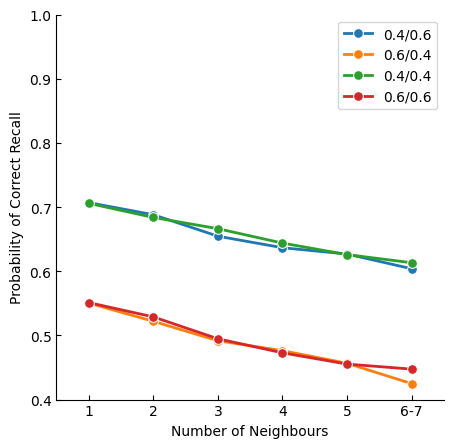

In [6]:
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_neighbor.query("neighbour_group > 0"), x='neighbour_group', y='correct_46', 
             linewidth=2, marker='o', markersize = 7, color = 'C0', label='0.4/0.6')
sns.lineplot(data=df_neighbor.query("neighbour_group > 0"), x='neighbour_group', y='correct_64', 
             linewidth=2, marker='o', markersize = 7, color = 'C1', label='0.6/0.4')
sns.lineplot(data=df_neighbor.query("neighbour_group > 0"), x='neighbour_group', y='correct_44', 
             linewidth=2, marker='o', markersize = 7, color = 'C2', label='0.4/0.4')
sns.lineplot(data=df_neighbor.query("neighbour_group > 0"), x='neighbour_group', y='correct_66', 
             linewidth=2, marker='o', markersize = 7, color = 'C3', label='0.6/0.6')
plt.ylim([0.4,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
plt.savefig('fig/simu8_4line_correct.pdf')
plt.show()

### ILI

In [7]:
with open("../Data/simu8b_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
face_distance = np.load('../Data/simu8_distance.npy')

In [8]:
def get_distance(df_tmp):
    faces = np.unique(df_tmp.test_itemno)
    face_dist = {}
    for face in faces:
        this_dist = []
        for other_face in faces:
            if face != other_face:
                this_dist.append(face_distance[face-1,other_face-1])
        this_dist = np.array(this_dist)
        face_dist[face] = this_dist
    y = df_tmp.apply(lambda x: face_dist[x['test_itemno']],axis=1)
    return y
df_test['distance'] = df_test.groupby("session").apply(get_distance).to_frame(name='distance').reset_index()['distance']
series_distance = df_test['distance']

In [9]:
def get_ILI_prob(df_simu):
    
    df_ILI = df_simu.loc[df_simu.ITI == True,:].copy()

    def get_resp_face(df_tmp):
        sess = np.unique(df_tmp.session).item()
        sess_name_face = df_study.query(f"session == {sess}")[["study_itemno1","study_itemno2"]].set_index("study_itemno2").to_dict()['study_itemno1']
        resp_face = df_tmp.apply(lambda x: sess_name_face[x['s_resp']],axis=1)
        return resp_face

    df_ILI['resp_face'] = df_ILI.groupby("session").apply(get_resp_face).to_frame().reset_index()[0].to_list()
    df_ILI['resp_corr_distance'] = df_ILI.apply(lambda x: face_distance[x['test_itemno']-1,x['resp_face']-1], axis=1)
    df_ILI['distance_bin'] = df_ILI.apply(lambda x: str(0.5 * (x['resp_corr_distance'] // 0.5 + 1)) if x['resp_corr_distance'] < 3.5 else ">3.5", axis=1)
    df_ILI['distance'] = series_distance

    distance_cnt = {}
    for lst in df_ILI.distance:
        for d in lst:
            d_group = str(0.5 * (d // 0.5 + 1)) if d < 3.5 else ">3.5"
            if d_group in distance_cnt:
                distance_cnt[d_group] += 1
            else:
                distance_cnt[d_group] = 1

    df_ILI_distance = df_ILI.groupby("distance_bin")['test_itemno'].count().to_frame(name='ILI_cnt').reset_index()
    df_ILI_distance['ILI_poss'] = df_ILI_distance.apply(lambda x: distance_cnt[x['distance_bin']], axis=1)
    df_ILI_distance['ILI_prob'] = df_ILI_distance['ILI_cnt'] / df_ILI_distance['ILI_poss']

    y = df_ILI_distance['ILI_prob'].to_list()
    return y

In [10]:
df_ILI = pd.DataFrame({"distance_bin":["1.0","1.5","2.0","2.5","3.0","3.5",">3.5"]})
df_ILI['ILI_46'] = get_ILI_prob(df_simu_46)
df_ILI['ILI_64'] = get_ILI_prob(df_simu_64)
df_ILI['ILI_44'] = get_ILI_prob(df_simu_44)
df_ILI['ILI_66'] = get_ILI_prob(df_simu_66)

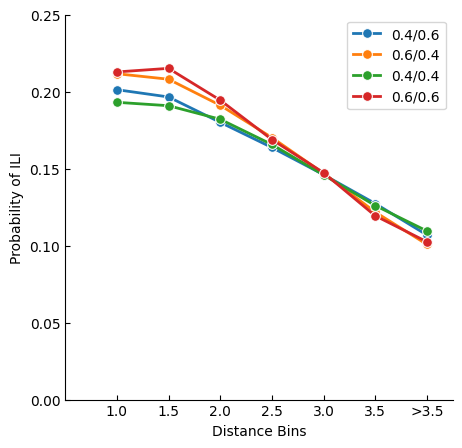

In [11]:
# ILI by distance bin
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_ILI, x='distance_bin', y='ILI_46', 
             linewidth=2, marker='o', markersize = 7, color='C0', label='0.4/0.6')
sns.lineplot(data=df_ILI, x='distance_bin', y='ILI_64', 
             linewidth=2, marker='o', markersize = 7, color='C1', label='0.6/0.4')
sns.lineplot(data=df_ILI, x='distance_bin', y='ILI_44', 
             linewidth=2, marker='o', markersize = 7, color='C2', label='0.4/0.4')
sns.lineplot(data=df_ILI, x='distance_bin', y='ILI_66', 
             linewidth=2, marker='o', markersize = 7, color='C3', label='0.6/0.6')
plt.ylim([0,0.25])
plt.xlim([-1,6.5])
plt.xlabel('Distance Bins')
plt.ylabel('Probability of ILI')
plt.savefig('fig/simu8_4line_ILI.pdf')
plt.show()